In [1]:
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error 
from matplotlib import pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings 
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, Activation, Bidirectional, LSTM, Dropout
from keras import optimizers
from keras.wrappers.scikit_learn import KerasClassifier
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)


train = pd.read_csv('gdp.csv', encoding="EUC-KR")

Using TensorFlow backend.


In [2]:
y = train['GDP']

In [3]:
train['Unnamed: 0'].iloc[66:]

66    2019_1
67    2019_2
68    2019_3
69    2019_4
70    2020_1
71    2020_2
72    2020_3
Name: Unnamed: 0, dtype: object

In [4]:
temp = train.iloc[66:]
test_x = temp.drop(['Unnamed: 0', 'GDP'], axis=1)
test_y = temp['GDP']
# 2019~2020 target GDP
# 2019-2020 X-variable


In [5]:
temp2 = train.iloc[:66]
# 2001~2018년 데이터

In [6]:
train_x = temp2.drop(['Unnamed: 0', 'GDP'], axis=1)
train_y = temp2['GDP']
# 2001~2018 target X varables

In [7]:
# 모양 확인
print(test_x.shape)
print(test_y.shape)
print(train_x.shape)
print(train_y.shape)

(7, 24)
(7,)
(66, 24)
(66,)


In [10]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso

# LR Ridge Lasso 로드

# 결과를 데이터프레임으로 저장하는 메소드

def get_result_df(test_y, pred):
    result = pd.DataFrame(test_y.values, columns=['real_gdp'])
    result['predict'] = np.round(pred)
    result['diff'] = result['real_gdp'] - result['predict']
    return result





# 각 모델별 rmse를 구하는 함수

def get_rmse_mae(model):
    pred = model.predict(test_x)
    mse = mean_squared_error(test_y, pred)
    mae = mean_absolute_error(test_y, pred)
    rmse = np.sqrt(mse)
    print(model.__class__.__name__, ' RMSE : ', np.round(rmse, 3))
    print(model.__class__.__name__, ' MAE : ', np.round(mae, 3))
    return rmse, mae

def get_rmses_maes(model):
    rmses=[]
    maes=[]
    for i in model:
        rmse, mae = get_rmse_mae(i)
        rmses.append(rmse)
        maes.append(mae)
    return rmses, maes




In [11]:
lr = LinearRegression()
lr.fit(train_x, train_y)
ridge = Ridge()
ridge.fit(train_x, train_y)
lasso = Lasso()
lasso.fit(train_x, train_y)

models = [lr ,ridge, lasso]
get_rmses_maes(models)
# 각 모델별 rmse mae 확인

LinearRegression  RMSE :  46574.42
LinearRegression  MAE :  35500.753
Ridge  RMSE :  46574.42
Ridge  MAE :  35500.753
Lasso  RMSE :  55708.636
Lasso  MAE :  42868.686


([46574.42034639082, 46574.42034638996, 55708.63584895265],
 [35500.75336074326, 35500.75336074269, 42868.68553427908])

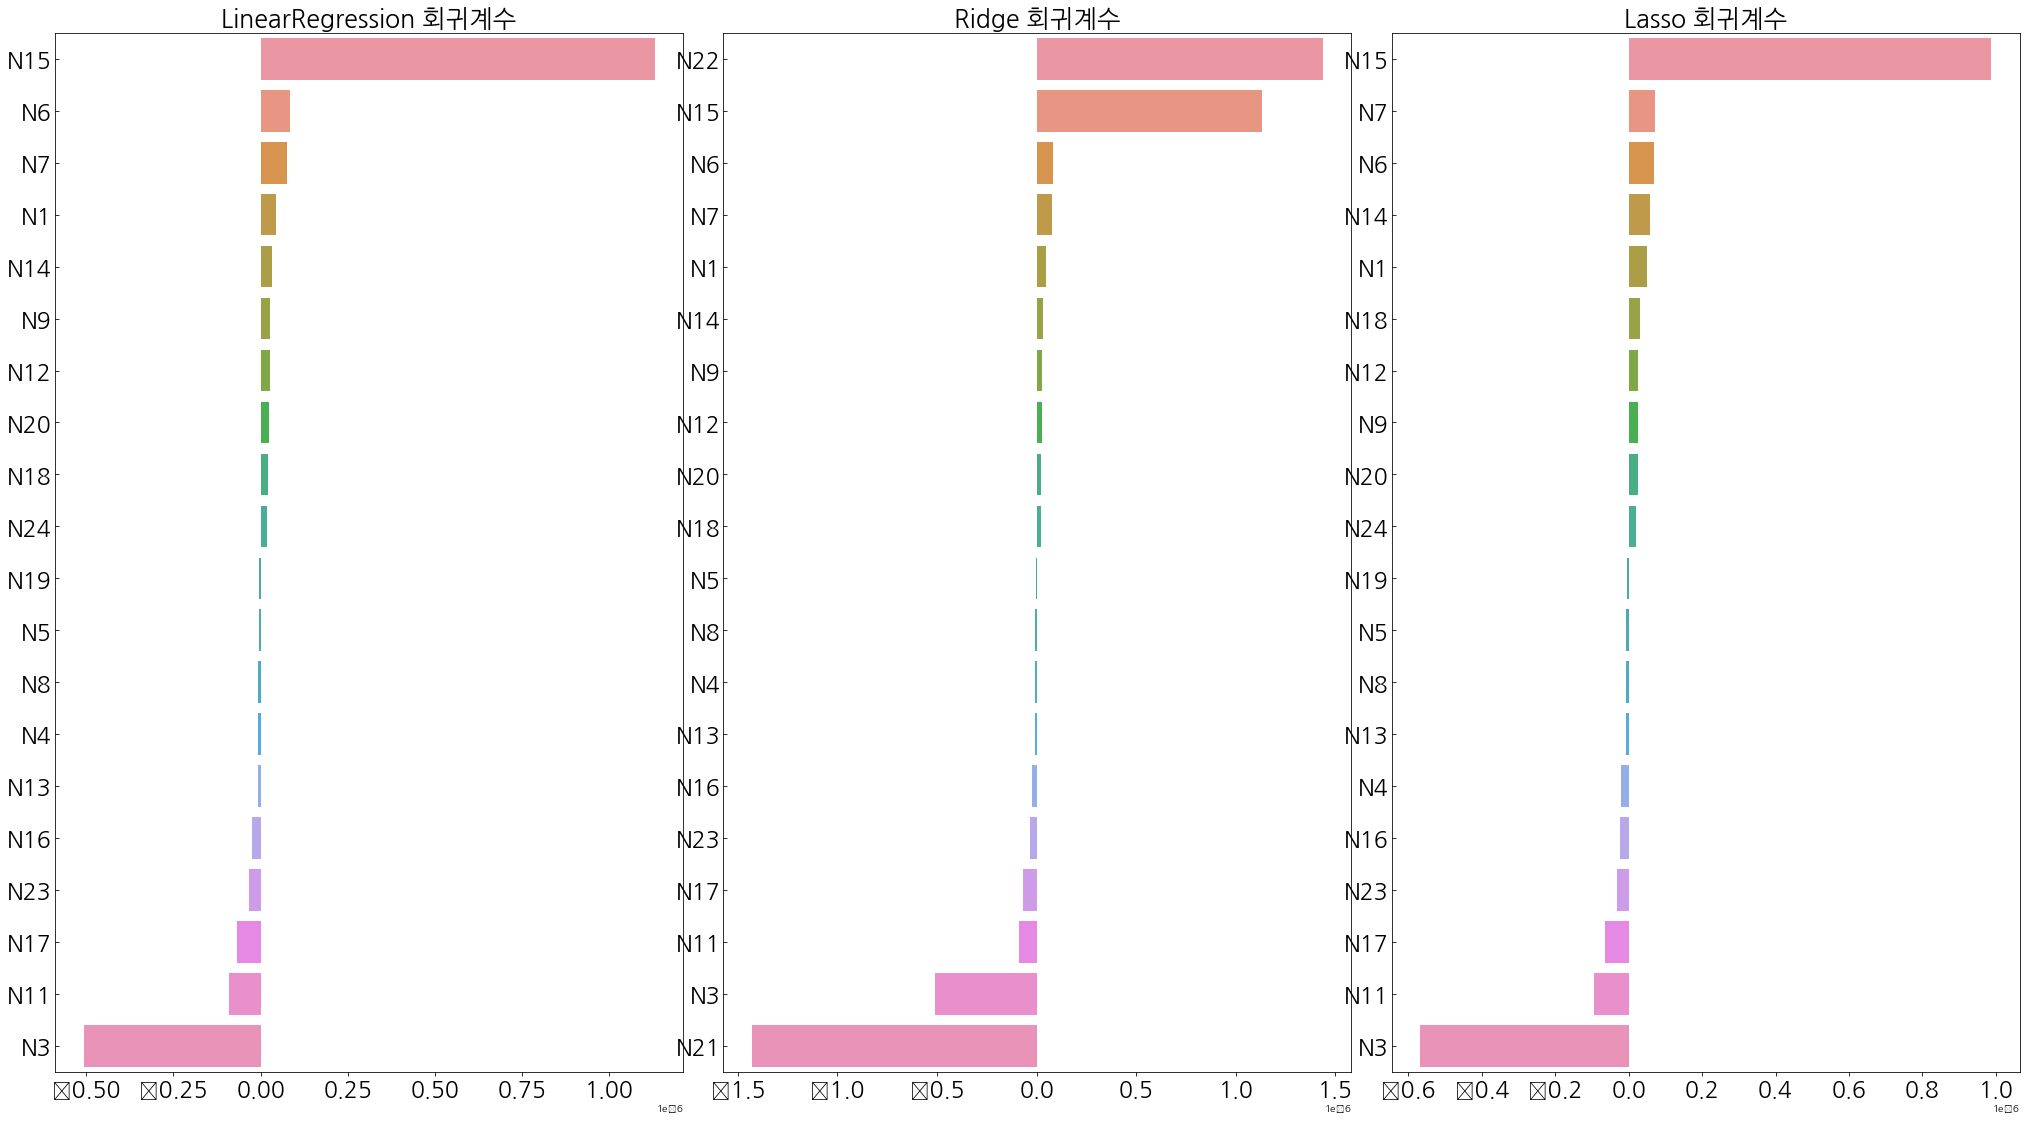

In [12]:
def get_top_bottom_coef(model , n=10):
    # coef 속성을 얻고 그래프 그리자
    coef = pd.Series(model.coef_, index=train_x.columns)
    
    # 상위 10개 하위 10개 회귀 계수를 추출
    coef_high = coef.sort_values(ascending=False).head(n)
    coef_low = coef.sort_values(ascending=False).tail(n)
    return coef_high, coef_low


# 회귀계수 그래프로 그리기
def draw_coef(models):
    # LR Lasso Ridge 그리기
    fig, axs = plt.subplots(figsize=(28,15), nrows=1, ncols=3)
    fig.tight_layout()
    # models에서 model 추출
    for num, model in enumerate(models):
        # 상위 10개 하위 10개 회귀계수 구한후 판다스로 결합후 그래프 그리자
        coef_high, coef_low = get_top_bottom_coef(model)
        coef_concat = pd.concat([coef_high, coef_low])
        # 막대 차트로 표현
        axs[num].set_title(model.__class__.__name__+" 회귀계수", size=25)
        axs[num].tick_params(axis="y", direction="in", pad=3)
        for label in (axs[num].get_xticklabels() + axs[num].get_yticklabels()):
            label.set_fontsize(23)
        sns.barplot(x=coef_concat.values, y=coef_concat.index, ax=axs[num])
plt.rcParams['font.family']='NanumGothic' # 한글폰트 추가   
models = [lr, ridge, lasso]
draw_coef(models)

In [13]:
# 몇 몇 개수가 너무 왜곡되었다
# average rmse확인후 어떻게 할지 결정

# lr lasso 비슷함
# n 23 17 11 13     이게 무슨 의미의 변수인지?

from sklearn.model_selection import cross_val_score

def get_avg_rmse_cv(models):
    
    for model in models:
        rmse_lst = np.sqrt(-cross_val_score(model, train_x, train_y, scoring="neg_mean_squared_error", cv=5))
        
        rmse_avg = np.mean(rmse_lst)
        print('\n{0} CV RMSE 값 리스트: {1}'.format(model.__class__.__name__, np.round(rmse_lst, 3)))
        print('{0} CV 평균 RMSE: {1}'.format(model.__class__.__name__, np.round(rmse_avg, 3)))

In [14]:
get_avg_rmse_cv(models)


LinearRegression CV RMSE 값 리스트: [10992.513  8392.272  8752.177  9780.78  20939.543]
LinearRegression CV 평균 RMSE: 11771.457

Ridge CV RMSE 값 리스트: [10992.513  8392.272  8752.177  9780.78  20939.543]
Ridge CV 평균 RMSE: 11771.457

Lasso CV RMSE 값 리스트: [ 9887.429  8228.263  9772.013 12082.596 21922.903]
Lasso CV 평균 RMSE: 12378.641


In [15]:
# 최적 변수를 return 하는 메소드 

def print_best_params(model, params):
    grid_model = GridSearchCV(model ,param_grid= params, scoring="neg_mean_squared_error", cv=5)
    # fit
    grid_model.fit(train_x, train_y)
    rmse = np.sqrt(-1*grid_model.best_score_)
    print('{0} 5 CV 최적 평균 RMSE:{1}, 최적 alpha:{2}'.format(model.__class__.__name__, np.round(rmse, 4), grid_model.best_params_))

In [16]:
ridge_params={'alpha':[0.05, 0.1, 1, 5, 8, 10, 12, 15, 20]}
lasso_params={'alpha':[0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1, 5, 10]}
print_best_params(ridge, ridge_params)
print_best_params(lasso, lasso_params)

Ridge 5 CV 최적 평균 RMSE:12664.8672, 최적 alpha:{'alpha': 10}
Lasso 5 CV 최적 평균 RMSE:13323.3672, 최적 alpha:{'alpha': 0.008}


LinearRegression  RMSE :  46574.42
LinearRegression  MAE :  35500.753
Ridge  RMSE :  46574.42
Ridge  MAE :  35500.753
Lasso  RMSE :  55708.636
Lasso  MAE :  42868.686


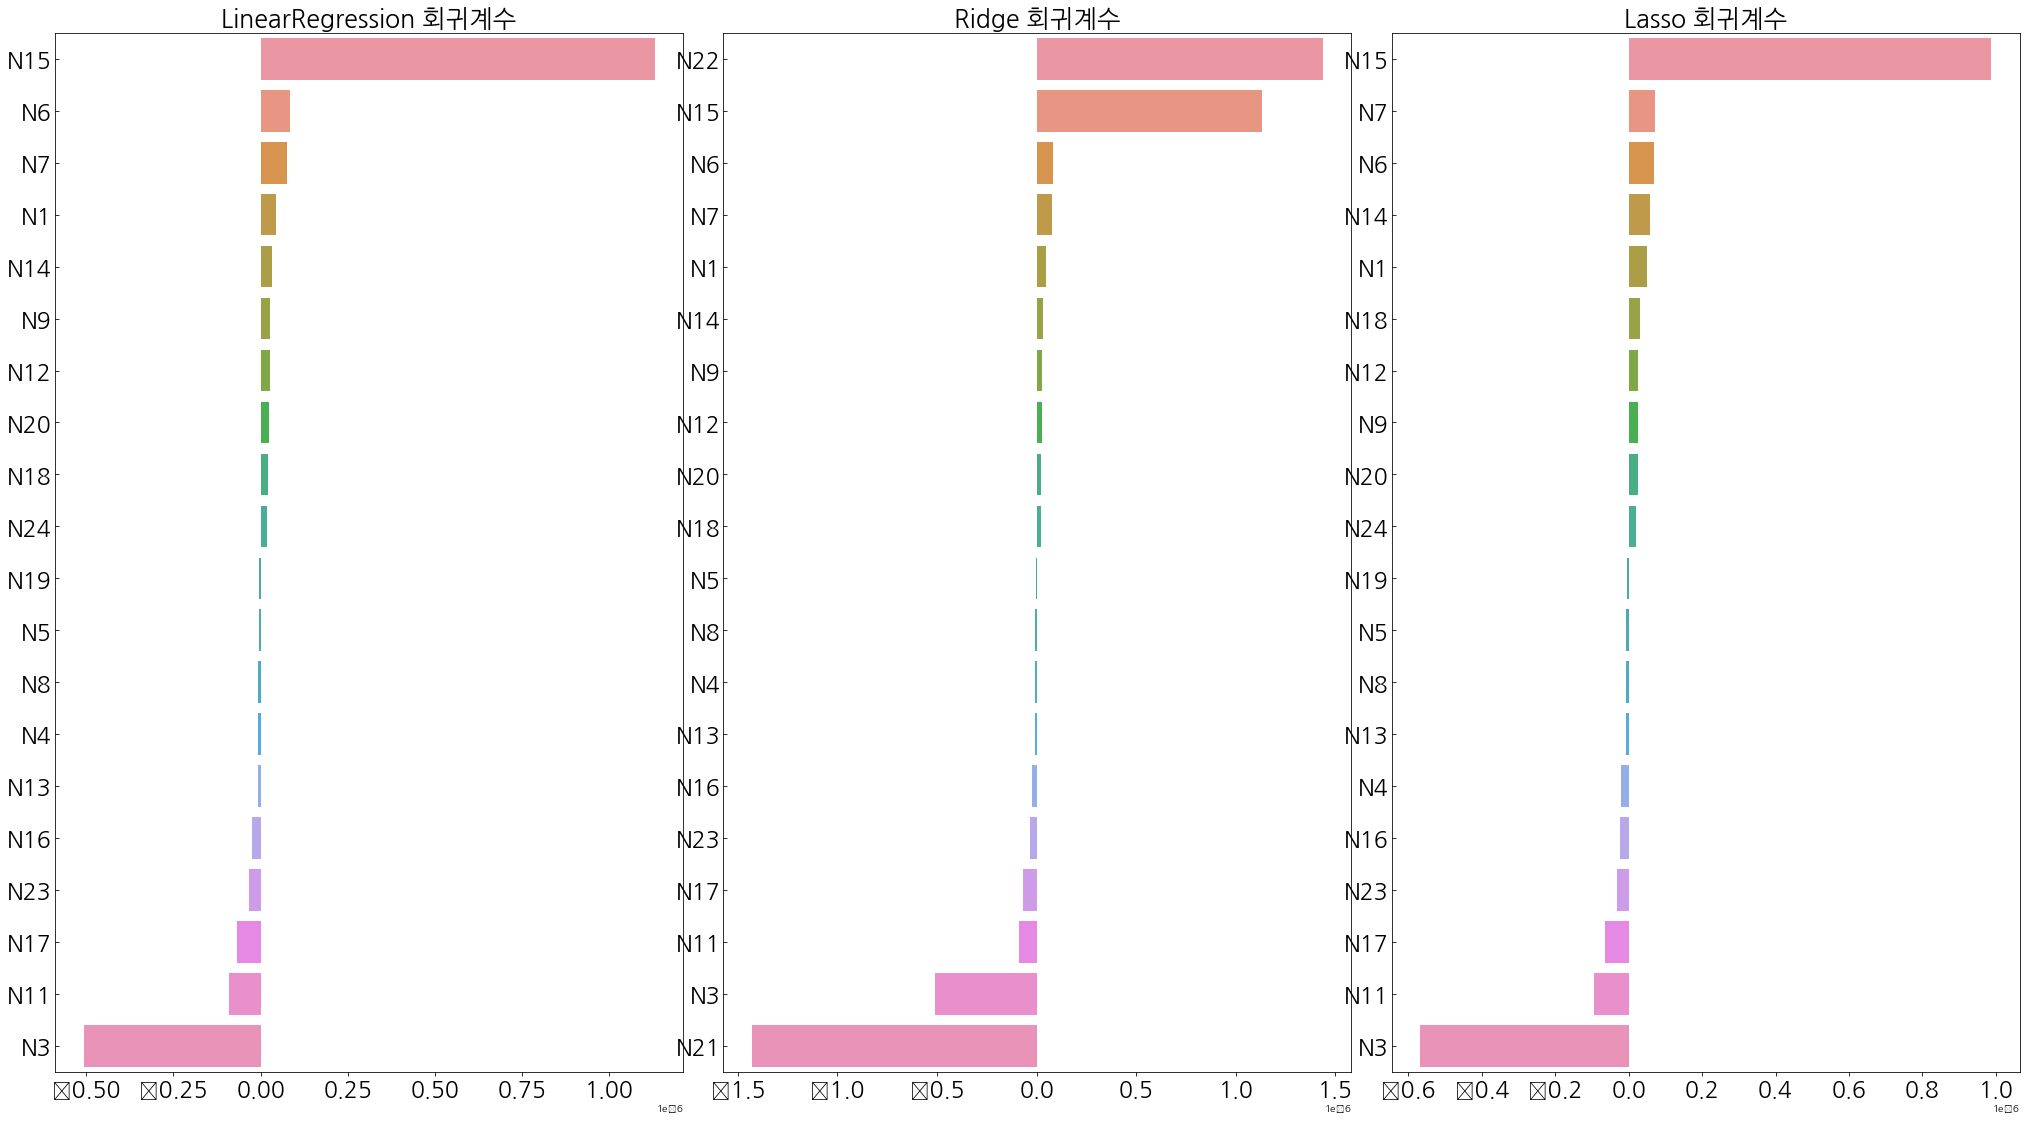

In [17]:
ridge=Ridge(alpha=10)
ridge.fit(train_x, train_y)
lasso = Lasso(alpha=0.008)
lasso.fit(train_x, train_y)



# rmse
models =[lr, ridge, lasso]
get_rmses_maes(models)

# 회귀 계수
draw_coef(models)



In [18]:
# 최적 변수를 찾아서 fit했지만 여전히 별로임
# X 변수중 skewness가 높은 것들을 로그변환을 실시

from scipy.stats import skew

# numeric feature
features_index = train_x.dtypes[train_x.dtypes!='object'].index

# skew 1이상만 log 변환 해볼까

skew_features = train_x[features_index].apply(lambda x : skew(x))

# 왜곡 1이상 칼럼만 추출
skew_features_top = skew_features[skew_features>1]
print(skew_features_top.sort_values(ascending=False))



N18    1.134135
N9     1.074114
dtype: float64


In [19]:
train_x[skew_features_top.index] = np.log1p(train_x[skew_features_top.index])
test_x[skew_features_top.index] = np.log1p(test_x[skew_features_top.index])
# skewness 1을 초과하면 로그변환 실시

In [21]:
ridge=Ridge()
lasso=Lasso()
ridge.fit(train_x, train_y)
lasso.fit(train_x, train_y)
print_best_params(ridge, ridge_params)
print_best_params(lasso, lasso_params)
# 이제 이 최적 계수를 우리의 alpha값으로 설정한다.
# 그리고 나서 새로 만든 변수에 대해 predict를 실시한다.

Ridge 5 CV 최적 평균 RMSE:11736.6514, 최적 alpha:{'alpha': 20}
Lasso 5 CV 최적 평균 RMSE:13248.1567, 최적 alpha:{'alpha': 10}


In [22]:
# 20부터 실시

test = pd.read_csv('new20.csv', encoding="EUC-KR")
test.drop('Unnamed: 0', axis=1, inplace = True)
test_x =test
test_x

,N1,N2,N3,N4,N5,N6,N7,N8,N9,N10,...,N15,N16,N17,N18,N19,N20,N21,N22,N23,N24
0,4.152411e+12,3.530393e+12,2.986725e+11,4.256757e+11,2.773454e+12,4.333628e+11,1.703161e+12,4.532229e+12,8.318833e+11,2.926234e+12,...,5.324120e+09,2.656403e+12,6.686688e+11,3.866796e+12,3.826561e+12,7.172954e+12,7.178118e+12,3.348087e+11,2.126026e+12,3.364178e+12
1,4.203317e+12,3.575273e+12,3.031054e+11,4.328640e+11,2.790322e+12,4.377308e+11,1.724989e+12,4.505464e+12,8.018781e+11,2.895971e+12,...,5.401355e+09,2.699146e+12,6.534065e+11,3.845057e+12,3.738828e+12,7.186265e+12,7.273217e+12,3.339689e+11,2.134304e+12,3.342622e+12
2,4.163982e+12,3.543133e+12,3.011109e+11,4.245294e+11,2.825825e+12,4.406786e+11,1.700012e+12,4.520483e+12,8.273607e+11,2.950518e+12,...,5.409122e+09,2.697606e+12,6.746895e+11,3.914672e+12,3.886415e+12,7.379017e+12,7.293492e+12,3.417565e+11,2.149118e+12,3.391487e+12
3,4.222809e+12,3.590224e+12,3.045862e+11,4.290992e+11,2.871012e+12,4.472511e+11,1.718078e+12,4.625071e+12,8.610489e+11,3.021971e+12,...,5.532075e+09,2.729952e+12,6.921159e+11,4.002677e+12,3.987122e+12,7.490262e+12,7.387672e+12,3.478213e+11,2.185951e+12,3.473058e+12
4,4.257846e+12,3.617996e+12,3.060839e+11,4.343384e+11,2.880372e+12,4.477512e+11,1.742100e+12,4.728595e+12,8.962512e+11,3.077690e+12,...,5.594577e+09,2.735376e+12,7.101751e+11,4.058652e+12,4.060488e+12,7.470658e+12,7.409039e+12,3.500046e+11,2.205212e+12,3.535665e+12
5,4.312755e+12,3.668429e+12,3.120642e+11,4.371221e+11,2.973423e+12,4.626233e+11,1.744138e+12,4.720806e+12,8.831619e+11,3.112824e+12,...,5.659927e+09,2.815225e+12,7.140585e+11,4.131065e+12,4.130052e+12,7.790761e+12,7.633152e+12,3.609886e+11,2.251871e+12,3.580628e+12
6,4.288461e+12,3.645579e+12,3.094248e+11,4.344717e+11,2.934837e+12,4.571128e+11,1.737204e+12,4.741662e+12,8.998329e+11,3.110377e+12,...,5.613772e+09,2.778258e+12,7.185800e+11,4.113277e+12,4.126739e+12,7.680292e+12,7.531752e+12,3.586881e+11,2.234398e+12,3.575015e+12


In [23]:
gdp20_train = train.iloc[:66]
gdp20_train

,Unnamed: 0,N1,N2,N3,N4,N5,N6,N7,N8,N9,...,N16,N17,N18,N19,N20,N21,N22,N23,N24,GDP
0,2001_1,1.310000e+12,7.830000e+11,4.844039e+10,1.440000e+11,8.300000e+11,1.020000e+11,2.830000e+11,1.450000e+12,8.480977e+10,...,8.040000e+11,2.440000e+11,6.400000e+11,2.220000e+12,1.750000e+12,1.640000e+12,1.640000e+12,5.360000e+11,5.750000e+11,210585.8
1,2001_2,1.190000e+12,8.670000e+11,4.500121e+10,1.500000e+11,7.880000e+11,1.210000e+11,3.300000e+11,1.300000e+12,1.200000e+11,...,8.400000e+11,1.730000e+11,6.050000e+11,6.140000e+11,1.840000e+12,1.760000e+12,1.760000e+12,4.900000e+11,7.010000e+11,225287.6
2,2001_3,1.390000e+12,1.070000e+12,5.752764e+10,1.590000e+11,6.880000e+11,1.050000e+11,3.250000e+11,1.020000e+12,1.170000e+11,...,8.900000e+11,1.590000e+11,6.500000e+11,2.050000e+12,1.820000e+12,1.840000e+12,1.840000e+12,4.590000e+11,5.930000e+11,230172.3
3,2001_4,1.440000e+12,8.610000e+11,4.583003e+10,1.570000e+11,1.070000e+12,1.170000e+11,3.380000e+11,1.130000e+12,2.130000e+11,...,9.210000e+11,2.270000e+11,6.040000e+11,6.320000e+11,1.860000e+12,1.880000e+12,1.880000e+12,5.350000e+11,6.850000e+11,237505.2
4,2002_1,1.430000e+12,8.890000e+11,5.337010e+10,1.610000e+11,9.620000e+11,1.190000e+11,3.840000e+11,1.450000e+12,1.300000e+11,...,1.020000e+12,2.050000e+11,7.000000e+11,2.380000e+12,2.060000e+12,1.900000e+12,1.900000e+12,6.110000e+11,6.590000e+11,221365.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61,2016_2,2.610000e+12,2.350000e+12,1.840000e+11,3.510000e+11,2.120000e+12,3.590000e+11,1.480000e+12,3.030000e+12,2.760000e+11,...,2.130000e+12,1.780000e+11,2.070000e+12,8.130000e+11,5.090000e+12,5.080000e+12,5.080000e+12,1.460000e+12,1.840000e+12,411511.3
62,2016_3,2.980000e+12,2.600000e+12,2.220000e+11,3.440000e+11,1.660000e+12,3.150000e+11,1.520000e+12,2.520000e+12,3.020000e+11,...,2.080000e+12,2.310000e+11,2.210000e+12,3.400000e+12,5.220000e+12,5.110000e+12,5.110000e+12,1.370000e+12,1.840000e+12,415415.8
63,2016_4,2.950000e+12,2.420000e+12,1.780000e+11,3.380000e+11,2.360000e+12,3.380000e+11,1.520000e+12,2.690000e+12,2.340000e+11,...,2.090000e+12,2.150000e+11,1.900000e+12,8.080000e+11,5.180000e+12,4.890000e+12,4.890000e+12,1.420000e+12,1.820000e+12,437752.4
64,2017_y,3.720000e+12,3.320000e+12,2.950000e+11,3.850000e+11,2.680000e+12,4.270000e+11,2.040000e+12,3.480000e+12,4.460000e+11,...,2.680000e+12,3.390000e+11,3.070000e+12,2.810000e+12,4.390000e+12,6.660000e+12,6.660000e+12,1.960000e+12,1.980000e+12,404410.5


In [24]:
train_x = gdp20_train.drop(['Unnamed: 0', 'GDP'], axis=1)
train_y = gdp20_train['GDP']

In [28]:
# 우리의 최적 모델에 fit한후 테스트를 실시한다
# 그전에 skewness를 처리해준다

# numeric feature
features_index = train_x.dtypes[train_x.dtypes!='object'].index

# skew 1이상만 log 변환 해볼까

skew_features = train_x[features_index].apply(lambda x : skew(x))

# 왜곡 1이상 칼럼만 추출
skew_features_top = skew_features[skew_features>1]
print(skew_features_top.sort_values(ascending=False))

N18    1.134135
N9     1.074114
dtype: float64


In [29]:

train_x[skew_features_top.index] = np.log1p(train_x[skew_features_top.index])
test_x[skew_features_top.index] = np.log1p(test_x[skew_features_top.index])

In [30]:
ridge=Ridge(alpha=20)
lasso=Lasso(alpha=10)
ridge.fit(train_x, train_y)
lasso.fit(train_x, train_y)
lr.fit(train_x, train_y)

LinearRegression()

In [31]:
# LR
print('LR', lr.predict(test_x))

# Lasso
print('Lasso', lasso.predict(test_x))

# ridege
print('Ridge', ridge.predict(test_x))

LR [1.72548775e+11 1.74967795e+11 1.75282651e+11 1.77504399e+11
 1.77988102e+11 1.83361996e+11 1.80863263e+11]
Lasso [438707.68121536 443329.77934474 444001.57979302 446380.64210747
 444923.84862885 454800.95363106 449774.4585089 ]
Ridge [-4473315.13771646 -4537477.57599691 -4545482.59012006 -4605812.35643368
 -4620641.84179402 -4763268.89591758 -4697295.95435679]


In [33]:
# predict 결과 Lasso모형이 가장 유의한 예측을 하였음
# predict결과를 DataFrame으로 변환
temp = train.iloc[66:]
test_y = temp['GDP']

pred = lasso.predict(test_x)
def get_result_df(test_y, pred):
    result = pd.DataFrame(test_y.values, columns=['real_gdp'])
    result['predict'] = np.round(pred)
    result['diff'] = result['real_gdp'] - result['predict']
    return result

a = get_result_df(test_y, pred)
print(a)

   real_gdp   predict     diff
0  426949.3  438708.0 -11758.7
1  449095.3  443330.0   5765.3
2  463086.0  444002.0  19084.0
3  487428.0  446381.0  41047.0
4  443200.0  444924.0  -1724.0
5  448715.0  454801.0  -6086.0
6  457856.0  449774.0   8082.0


In [34]:
# new20 일때 통계값
# 확인 결과 실제 gdp에 못미치는 효과

a.describe()

,real_gdp,predict,diff
count,7.000000,7.000000,7.000000
mean,453761.371429,445988.571429,7772.800000
std,18774.203882,5120.170370,17809.062917
min,426949.300000,438708.000000,-11758.700000
25%,445957.500000,443666.000000,-3905.000000
50%,449095.300000,444924.000000,5765.300000
75%,460471.000000,448077.500000,13583.000000
max,487428.000000,454801.000000,41047.000000


In [37]:
# 30 실시

test = pd.read_csv('new30.csv', encoding="EUC-KR")
test.drop('Unnamed: 0', axis=1, inplace = True)
test_x =test
test_x

,N1,N2,N3,N4,N5,N6,N7,N8,N9,N10,...,N15,N16,N17,N18,N19,N20,N21,N22,N23,N24
0,4.206437e+12,3.577141e+12,3.029488e+11,4.309221e+11,2.825234e+12,4.415852e+11,1.724593e+12,4.592929e+12,8.452514e+11,2.975828e+12,...,5.436001e+09,2.701725e+12,6.798950e+11,3.936193e+12,3.901224e+12,7.327468e+12,7.304578e+12,3.417758e+11,2.160713e+12,3.422441e+12
1,4.258912e+12,3.623055e+12,3.076721e+11,4.377797e+11,2.843965e+12,4.458882e+11,1.743331e+12,4.565084e+12,8.139104e+11,2.946759e+12,...,5.492605e+09,2.748083e+12,6.671871e+11,3.916814e+12,3.817405e+12,7.356030e+12,7.406225e+12,3.414825e+11,2.170205e+12,3.400037e+12
2,4.217733e+12,3.589112e+12,3.053098e+11,4.290315e+11,2.878044e+12,4.485820e+11,1.717436e+12,4.580325e+12,8.414159e+11,3.000736e+12,...,5.493047e+09,2.741787e+12,6.865731e+11,3.983965e+12,3.962540e+12,7.533731e+12,7.417862e+12,3.484965e+11,2.184061e+12,3.449542e+12
3,4.274833e+12,3.635357e+12,3.087760e+11,4.344685e+11,2.919722e+12,4.545471e+11,1.738804e+12,4.686479e+12,8.753441e+11,3.071345e+12,...,5.623772e+09,2.774170e+12,7.048925e+11,4.070128e+12,4.058864e+12,7.629519e+12,7.510940e+12,3.543399e+11,2.219600e+12,3.531470e+12
4,4.311889e+12,3.664111e+12,3.105789e+11,4.397776e+11,2.932913e+12,4.558715e+11,1.764143e+12,4.788655e+12,9.093894e+11,3.127881e+12,...,5.698860e+09,2.781123e+12,7.213301e+11,4.128128e+12,4.135678e+12,7.625452e+12,7.537718e+12,3.566590e+11,2.240429e+12,3.593603e+12
5,4.368311e+12,3.714975e+12,3.164352e+11,4.416843e+11,3.027039e+12,4.708176e+11,1.758971e+12,4.780140e+12,8.969048e+11,3.162857e+12,...,5.743357e+09,2.860464e+12,7.270303e+11,4.200830e+12,4.209049e+12,7.952076e+12,7.759269e+12,3.681668e+11,2.288521e+12,3.637379e+12
6,4.336442e+12,3.686483e+12,3.133450e+11,4.389647e+11,2.984498e+12,4.648385e+11,1.753021e+12,4.800490e+12,9.157078e+11,3.160313e+12,...,5.684502e+09,2.818436e+12,7.305469e+11,4.181073e+12,4.204803e+12,7.832441e+12,7.648293e+12,3.653664e+11,2.268033e+12,3.632587e+12


In [38]:
gdp30_train = train.iloc[:66]
gdp30_train

,Unnamed: 0,N1,N2,N3,N4,N5,N6,N7,N8,N9,...,N16,N17,N18,N19,N20,N21,N22,N23,N24,GDP
0,2001_1,1.310000e+12,7.830000e+11,4.844039e+10,1.440000e+11,8.300000e+11,1.020000e+11,2.830000e+11,1.450000e+12,8.480977e+10,...,8.040000e+11,2.440000e+11,6.400000e+11,2.220000e+12,1.750000e+12,1.640000e+12,1.640000e+12,5.360000e+11,5.750000e+11,210585.8
1,2001_2,1.190000e+12,8.670000e+11,4.500121e+10,1.500000e+11,7.880000e+11,1.210000e+11,3.300000e+11,1.300000e+12,1.200000e+11,...,8.400000e+11,1.730000e+11,6.050000e+11,6.140000e+11,1.840000e+12,1.760000e+12,1.760000e+12,4.900000e+11,7.010000e+11,225287.6
2,2001_3,1.390000e+12,1.070000e+12,5.752764e+10,1.590000e+11,6.880000e+11,1.050000e+11,3.250000e+11,1.020000e+12,1.170000e+11,...,8.900000e+11,1.590000e+11,6.500000e+11,2.050000e+12,1.820000e+12,1.840000e+12,1.840000e+12,4.590000e+11,5.930000e+11,230172.3
3,2001_4,1.440000e+12,8.610000e+11,4.583003e+10,1.570000e+11,1.070000e+12,1.170000e+11,3.380000e+11,1.130000e+12,2.130000e+11,...,9.210000e+11,2.270000e+11,6.040000e+11,6.320000e+11,1.860000e+12,1.880000e+12,1.880000e+12,5.350000e+11,6.850000e+11,237505.2
4,2002_1,1.430000e+12,8.890000e+11,5.337010e+10,1.610000e+11,9.620000e+11,1.190000e+11,3.840000e+11,1.450000e+12,1.300000e+11,...,1.020000e+12,2.050000e+11,7.000000e+11,2.380000e+12,2.060000e+12,1.900000e+12,1.900000e+12,6.110000e+11,6.590000e+11,221365.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61,2016_2,2.610000e+12,2.350000e+12,1.840000e+11,3.510000e+11,2.120000e+12,3.590000e+11,1.480000e+12,3.030000e+12,2.760000e+11,...,2.130000e+12,1.780000e+11,2.070000e+12,8.130000e+11,5.090000e+12,5.080000e+12,5.080000e+12,1.460000e+12,1.840000e+12,411511.3
62,2016_3,2.980000e+12,2.600000e+12,2.220000e+11,3.440000e+11,1.660000e+12,3.150000e+11,1.520000e+12,2.520000e+12,3.020000e+11,...,2.080000e+12,2.310000e+11,2.210000e+12,3.400000e+12,5.220000e+12,5.110000e+12,5.110000e+12,1.370000e+12,1.840000e+12,415415.8
63,2016_4,2.950000e+12,2.420000e+12,1.780000e+11,3.380000e+11,2.360000e+12,3.380000e+11,1.520000e+12,2.690000e+12,2.340000e+11,...,2.090000e+12,2.150000e+11,1.900000e+12,8.080000e+11,5.180000e+12,4.890000e+12,4.890000e+12,1.420000e+12,1.820000e+12,437752.4
64,2017_y,3.720000e+12,3.320000e+12,2.950000e+11,3.850000e+11,2.680000e+12,4.270000e+11,2.040000e+12,3.480000e+12,4.460000e+11,...,2.680000e+12,3.390000e+11,3.070000e+12,2.810000e+12,4.390000e+12,6.660000e+12,6.660000e+12,1.960000e+12,1.980000e+12,404410.5


In [39]:
train_x = gdp20_train.drop(['Unnamed: 0', 'GDP'], axis=1)
train_y = gdp20_train['GDP']

In [40]:
features_index = train_x.dtypes[train_x.dtypes!='object'].index
skew_features = train_x[features_index].apply(lambda x : skew(x))
skew_features_top = skew_features[skew_features>1]
print(skew_features_top.sort_values(ascending=False))


N18    1.134135
N9     1.074114
dtype: float64


In [41]:
train_x[skew_features_top.index] = np.log1p(train_x[skew_features_top.index])
test_x[skew_features_top.index] = np.log1p(test_x[skew_features_top.index])


In [42]:
ridge=Ridge(alpha=20)
lasso=Lasso(alpha=10)
ridge.fit(train_x, train_y)
lasso.fit(train_x, train_y)
lr.fit(train_x, train_y)


# LR
print('LR', lr.predict(test_x))

# Lasso
print('Lasso', lasso.predict(test_x))

# ridege
print('Ridge', ridge.predict(test_x))


LR [1.75561695e+11 1.78132027e+11 1.78248607e+11 1.80448160e+11
 1.81064861e+11 1.86360941e+11 1.83633378e+11]
Lasso [443636.61931054 448002.0342557  448493.79564061 450512.09301819
 449773.24915228 459066.25858328 453900.27961177]
Ridge [-4553620.44475753 -4622319.56862899 -4624931.46328129 -4684954.66250839
 -4702805.60622947 -4843854.27276506 -4771525.99730289]


In [46]:
# 변수가 30개인 버전도 lasso가 가장 좋음
# 데이터 프레임으로 저장
temp = train.iloc[66:]
test_y = temp['GDP']

pred = lasso.predict(test_x)


b = get_result_df(test_y, pred)
print(b)

   real_gdp   predict     diff
0  426949.3  443637.0 -16687.7
1  449095.3  448002.0   1093.3
2  463086.0  448494.0  14592.0
3  487428.0  450512.0  36916.0
4  443200.0  449773.0  -6573.0
5  448715.0  459066.0 -10351.0
6  457856.0  453900.0   3956.0


In [47]:
b.describe()

# 아직 실제 gdp보다 낮지만 20개일때보다는 상승함

,real_gdp,predict,diff
count,7.000000,7.000000,7.000000
mean,453761.371429,450483.428571,3277.942857
std,18774.203882,4879.001191,18010.067817
min,426949.300000,443637.000000,-16687.700000
25%,445957.500000,448248.000000,-8462.000000
50%,449095.300000,449773.000000,1093.300000
75%,460471.000000,452206.000000,9274.000000
max,487428.000000,459066.000000,36916.000000


In [48]:
# 50개 시작

test = pd.read_csv('new50.csv', encoding="EUC-KR")

In [49]:
test.drop('Unnamed: 0', axis=1, inplace = True)

In [50]:
test_x =test
test_x

,N1,N2,N3,N4,N5,N6,N7,N8,N9,N10,...,N15,N16,N17,N18,N19,N20,N21,N22,N23,N24
0,4.314851e+12,3.668547e+12,3.115843e+11,4.406684e+11,2.936536e+12,4.583126e+11,1.760787e+12,4.731913e+12,8.819328e+11,3.092995e+12,...,5.640486e+09,2.794658e+12,7.100828e+11,4.094195e+12,4.081569e+12,7.660198e+12,7.567286e+12,3.570286e+11,2.236241e+12,3.556245e+12
1,4.358290e+12,3.706819e+12,3.155245e+11,4.445177e+11,2.960375e+12,4.627678e+11,1.767338e+12,4.701256e+12,8.534294e+11,3.069685e+12,...,5.653923e+09,2.834383e+12,6.994361e+11,4.082095e+12,4.024798e+12,7.720935e+12,7.659643e+12,3.574466e+11,2.247704e+12,3.537155e+12
2,4.314482e+12,3.670648e+12,3.127706e+11,4.362342e+11,2.988737e+12,4.645430e+11,1.742161e+12,4.718384e+12,8.825551e+11,3.122292e+12,...,5.642247e+09,2.824462e+12,7.187123e+11,4.145601e+12,4.163511e+12,7.873657e+12,7.660658e+12,3.637855e+11,2.259117e+12,3.585983e+12
3,4.369602e+12,3.715063e+12,3.162109e+11,4.409351e+11,3.027441e+12,4.702832e+11,1.761906e+12,4.824491e+12,9.164776e+11,3.190878e+12,...,5.774746e+09,2.856318e+12,7.377258e+11,4.230610e+12,4.257761e+12,7.966525e+12,7.750295e+12,3.698803e+11,2.292909e+12,3.666535e+12
4,4.414716e+12,3.751242e+12,3.185219e+11,4.473145e+11,3.044679e+12,4.718504e+11,1.794618e+12,4.924918e+12,9.462809e+11,3.246287e+12,...,5.880855e+09,2.867826e+12,7.523034e+11,4.287834e+12,4.330033e+12,7.963065e+12,7.787904e+12,3.716588e+11,2.315937e+12,3.726907e+12
5,4.455451e+12,3.787790e+12,3.232585e+11,4.456569e+11,3.134699e+12,4.861453e+11,1.778767e+12,4.914996e+12,9.410164e+11,3.284469e+12,...,5.925183e+09,2.937765e+12,7.602298e+11,4.365813e+12,4.419753e+12,8.311017e+12,7.983538e+12,3.841079e+11,2.359791e+12,3.772055e+12
6,4.422878e+12,3.758571e+12,3.198307e+11,4.439379e+11,3.089220e+12,4.791268e+11,1.773200e+12,4.938247e+12,9.595174e+11,3.282332e+12,...,5.857609e+09,2.894005e+12,7.649798e+11,4.342778e+12,4.414676e+12,8.168789e+12,7.867907e+12,3.802061e+11,2.338908e+12,3.765210e+12


In [51]:
gdp50_train = train.iloc[:66]
gdp50_train

,Unnamed: 0,N1,N2,N3,N4,N5,N6,N7,N8,N9,...,N16,N17,N18,N19,N20,N21,N22,N23,N24,GDP
0,2001_1,1.310000e+12,7.830000e+11,4.844039e+10,1.440000e+11,8.300000e+11,1.020000e+11,2.830000e+11,1.450000e+12,8.480977e+10,...,8.040000e+11,2.440000e+11,6.400000e+11,2.220000e+12,1.750000e+12,1.640000e+12,1.640000e+12,5.360000e+11,5.750000e+11,210585.8
1,2001_2,1.190000e+12,8.670000e+11,4.500121e+10,1.500000e+11,7.880000e+11,1.210000e+11,3.300000e+11,1.300000e+12,1.200000e+11,...,8.400000e+11,1.730000e+11,6.050000e+11,6.140000e+11,1.840000e+12,1.760000e+12,1.760000e+12,4.900000e+11,7.010000e+11,225287.6
2,2001_3,1.390000e+12,1.070000e+12,5.752764e+10,1.590000e+11,6.880000e+11,1.050000e+11,3.250000e+11,1.020000e+12,1.170000e+11,...,8.900000e+11,1.590000e+11,6.500000e+11,2.050000e+12,1.820000e+12,1.840000e+12,1.840000e+12,4.590000e+11,5.930000e+11,230172.3
3,2001_4,1.440000e+12,8.610000e+11,4.583003e+10,1.570000e+11,1.070000e+12,1.170000e+11,3.380000e+11,1.130000e+12,2.130000e+11,...,9.210000e+11,2.270000e+11,6.040000e+11,6.320000e+11,1.860000e+12,1.880000e+12,1.880000e+12,5.350000e+11,6.850000e+11,237505.2
4,2002_1,1.430000e+12,8.890000e+11,5.337010e+10,1.610000e+11,9.620000e+11,1.190000e+11,3.840000e+11,1.450000e+12,1.300000e+11,...,1.020000e+12,2.050000e+11,7.000000e+11,2.380000e+12,2.060000e+12,1.900000e+12,1.900000e+12,6.110000e+11,6.590000e+11,221365.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61,2016_2,2.610000e+12,2.350000e+12,1.840000e+11,3.510000e+11,2.120000e+12,3.590000e+11,1.480000e+12,3.030000e+12,2.760000e+11,...,2.130000e+12,1.780000e+11,2.070000e+12,8.130000e+11,5.090000e+12,5.080000e+12,5.080000e+12,1.460000e+12,1.840000e+12,411511.3
62,2016_3,2.980000e+12,2.600000e+12,2.220000e+11,3.440000e+11,1.660000e+12,3.150000e+11,1.520000e+12,2.520000e+12,3.020000e+11,...,2.080000e+12,2.310000e+11,2.210000e+12,3.400000e+12,5.220000e+12,5.110000e+12,5.110000e+12,1.370000e+12,1.840000e+12,415415.8
63,2016_4,2.950000e+12,2.420000e+12,1.780000e+11,3.380000e+11,2.360000e+12,3.380000e+11,1.520000e+12,2.690000e+12,2.340000e+11,...,2.090000e+12,2.150000e+11,1.900000e+12,8.080000e+11,5.180000e+12,4.890000e+12,4.890000e+12,1.420000e+12,1.820000e+12,437752.4
64,2017_y,3.720000e+12,3.320000e+12,2.950000e+11,3.850000e+11,2.680000e+12,4.270000e+11,2.040000e+12,3.480000e+12,4.460000e+11,...,2.680000e+12,3.390000e+11,3.070000e+12,2.810000e+12,4.390000e+12,6.660000e+12,6.660000e+12,1.960000e+12,1.980000e+12,404410.5


In [52]:
train_x = gdp50_train.drop(['Unnamed: 0', 'GDP'], axis=1)
train_y = gdp50_train['GDP']

In [53]:
train_x # 확인

,N1,N2,N3,N4,N5,N6,N7,N8,N9,N10,...,N15,N16,N17,N18,N19,N20,N21,N22,N23,N24
0,1.310000e+12,7.830000e+11,4.844039e+10,1.440000e+11,8.300000e+11,1.020000e+11,2.830000e+11,1.450000e+12,8.480977e+10,3.250000e+11,...,1765788293,8.040000e+11,2.440000e+11,6.400000e+11,2.220000e+12,1.750000e+12,1.640000e+12,1.640000e+12,5.360000e+11,5.750000e+11
1,1.190000e+12,8.670000e+11,4.500121e+10,1.500000e+11,7.880000e+11,1.210000e+11,3.300000e+11,1.300000e+12,1.200000e+11,4.190000e+11,...,1605546114,8.400000e+11,1.730000e+11,6.050000e+11,6.140000e+11,1.840000e+12,1.760000e+12,1.760000e+12,4.900000e+11,7.010000e+11
2,1.390000e+12,1.070000e+12,5.752764e+10,1.590000e+11,6.880000e+11,1.050000e+11,3.250000e+11,1.020000e+12,1.170000e+11,4.590000e+11,...,1337901783,8.900000e+11,1.590000e+11,6.500000e+11,2.050000e+12,1.820000e+12,1.840000e+12,1.840000e+12,4.590000e+11,5.930000e+11
3,1.440000e+12,8.610000e+11,4.583003e+10,1.570000e+11,1.070000e+12,1.170000e+11,3.380000e+11,1.130000e+12,2.130000e+11,4.700000e+11,...,2367251675,9.210000e+11,2.270000e+11,6.040000e+11,6.320000e+11,1.860000e+12,1.880000e+12,1.880000e+12,5.350000e+11,6.850000e+11
4,1.430000e+12,8.890000e+11,5.337010e+10,1.610000e+11,9.620000e+11,1.190000e+11,3.840000e+11,1.450000e+12,1.300000e+11,4.100000e+11,...,2228925795,1.020000e+12,2.050000e+11,7.000000e+11,2.380000e+12,2.060000e+12,1.900000e+12,1.900000e+12,6.110000e+11,6.590000e+11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61,2.610000e+12,2.350000e+12,1.840000e+11,3.510000e+11,2.120000e+12,3.590000e+11,1.480000e+12,3.030000e+12,2.760000e+11,1.300000e+12,...,4149111826,2.130000e+12,1.780000e+11,2.070000e+12,8.130000e+11,5.090000e+12,5.080000e+12,5.080000e+12,1.460000e+12,1.840000e+12
62,2.980000e+12,2.600000e+12,2.220000e+11,3.440000e+11,1.660000e+12,3.150000e+11,1.520000e+12,2.520000e+12,3.020000e+11,1.510000e+12,...,3848464547,2.080000e+12,2.310000e+11,2.210000e+12,3.400000e+12,5.220000e+12,5.110000e+12,5.110000e+12,1.370000e+12,1.840000e+12
63,2.950000e+12,2.420000e+12,1.780000e+11,3.380000e+11,2.360000e+12,3.380000e+11,1.520000e+12,2.690000e+12,2.340000e+11,1.370000e+12,...,4726512972,2.090000e+12,2.150000e+11,1.900000e+12,8.080000e+11,5.180000e+12,4.890000e+12,4.890000e+12,1.420000e+12,1.820000e+12
64,3.720000e+12,3.320000e+12,2.950000e+11,3.850000e+11,2.680000e+12,4.270000e+11,2.040000e+12,3.480000e+12,4.460000e+11,1.740000e+12,...,7183366304,2.680000e+12,3.390000e+11,3.070000e+12,2.810000e+12,4.390000e+12,6.660000e+12,6.660000e+12,1.960000e+12,1.980000e+12


In [54]:
train_y # 확인

0     210585.8
1     225287.6
2     230172.3
3     237505.2
4     221365.2
        ...   
61    411511.3
62    415415.8
63    437752.4
64    404410.5
65    426425.2
Name: GDP, Length: 66, dtype: float64

In [55]:
print('24개 버전 트레인 데이터 shape')
print(train_x.shape)
print(train_y.shape)
print('24개 버전 테스트 데이터 shape')
print(test_x.shape)
#print(test_y.shape)


24개 버전 트레인 데이터 shape
(66, 24)
(66,)
24개 버전 테스트 데이터 shape
(7, 24)


In [56]:
features_index = train_x.dtypes[train_x.dtypes!='object'].index
skew_features = train_x[features_index].apply(lambda x : skew(x))
skew_features_top = skew_features[skew_features>1]
print(skew_features_top.sort_values(ascending=False))

N18    1.134135
N9     1.074114
dtype: float64


In [58]:

train_x[skew_features_top.index] = np.log1p(train_x[skew_features_top.index])
test_x[skew_features_top.index] = np.log1p(test_x[skew_features_top.index])

In [59]:
# 로그변환 효과 있음음

ridge=Ridge(alpha=20)
lasso=Lasso(alpha=10)
ridge.fit(train_x, train_y)
lasso.fit(train_x, train_y)
lr.fit(train_x, train_y)

# LR
print('LR', lr.predict(test_x))

# Lasso
print('Lasso', lasso.predict(test_x))

# ridege
print('Ridge', ridge.predict(test_x))

LR [1.81801070e+11 1.84119236e+11 1.83985016e+11 1.86091467e+11
 1.86994889e+11 1.91613749e+11 1.88796593e+11]
Lasso [452431.53423452 456594.88424549 456405.86299807 457950.28645365
 458276.04266639 466660.4489482  460868.69478751]
Ridge [-4721276.38755437 -4783092.6914562  -4779270.53197556 -4837074.09852864
 -4861975.45015553 -4984636.69605045 -4910421.04823785]


In [60]:
temp = train.iloc[66:]
test_y = temp['GDP']

In [62]:
pred = lasso.predict(test_x)
c = get_result_df(test_y, pred)

In [63]:
c

,real_gdp,predict,diff
0,426949.3,452432.0,-25482.7
1,449095.3,456595.0,-7499.7
2,463086.0,456406.0,6680.0
3,487428.0,457950.0,29478.0
4,443200.0,458276.0,-15076.0
5,448715.0,466660.0,-17945.0
6,457856.0,460869.0,-3013.0


In [64]:
c.describe()
# 50개 변수를 사용했을때 가정한 기본소득 모델이 실제 gdp보다 향상된다는 결과가 나옴.
# 이 결과 기본소득 제도의 실시는 gdp의 향상을 가져온다고 결론을 내릴 수 있음.

,real_gdp,predict,diff
count,7.000000,7.000000,7.000000
mean,453761.371429,458455.428571,-4694.057143
std,18774.203882,4422.876434,18363.624126
min,426949.300000,452432.000000,-25482.700000
25%,445957.500000,456500.500000,-16510.500000
50%,449095.300000,457950.000000,-7499.700000
75%,460471.000000,459572.500000,1833.500000
max,487428.000000,466660.000000,29478.000000


In [66]:
a.rename({'predict' :'Var20_predict'}, axis='columns', inplace=True)

In [68]:
b.rename({'predict' :'Var30_predict'}, axis='columns', inplace=True)
c.rename({'predict' :'Var50_predict'}, axis='columns', inplace=True)

In [72]:
# 모든 결과를 새로운 데이터프레임에 병합후 결과를 반환한다.

final_result = pd.concat([a.iloc[:, :2], b.iloc[:, 1], c.iloc[:, 1]], axis=1)

In [74]:
final_result.to_csv('final_gdp_result.csv', index=False)

In [76]:
c.describe().to_csv('new50_gdp_stat.csv')

In [77]:
a.describe().to_csv('new20_gdp_stat.csv')
b.describe().to_csv('new30_gdp_stat.csv')